In [2]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import torch as th 
import torch.nn as nn 
import torch.nn.functional as F
import itertools
import matplotlib
import matplotlib.pyplot as plt 


# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

In [3]:
# # Download mnist dataset 
# if("mnist.pkl.gz" not in os.listdir(".")):
#     !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "../mnist.pkl.gz"

In [4]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

# Part one: MNIST classification with Pytorch
The goal of the first part is to learn how to use Pytorch and to observe the impact of regularization during training. You should test different network architectures, e.g. with hidden layers of size 128-128, 128-64-32-16, 256-128-64-32-16, 512-256-128-64-32-16, 800-800, and different activation functions (tanh, relu, sigmoid).

Remember that Pytorch expects data in a different format than in the previous lab exercise: the first dimension is always the batch dimension.

In [5]:
image = th.from_numpy(train_data[0][0])
print(image.shape) # flat image of dim (784,)

# reshape the tensor so it is represented as a batch containing a single image
# -1 means "all remaining elements", here it would be equivalent to image.reshape(1, 784)
image = image.reshape(1, -1)
print(image.shape) # flat image of dim (1, 784)

torch.Size([784])
torch.Size([1, 784])


## 1.2. Layer initialization¶
By default, Pytorch will apply Kaiming initialization to linear layers. However, I recommend you to always explicitly initialize you network by hand in the constructor.

## 1.3. Regularization

You can try two types of regularization (they can be combined together):

weight decay:��it is a parameter of the optimizer
dropout: see slides

## 1.4. Gradient clipping

A commong trick for training neural networks is gradient clipping: if the norm of the gradient is too big, we rescale the gradient. This trick can be used to prevent exploding gradients and also to make "too big steps" in the wrong direction due the use of approximate gradient computation in SGD.

In [7]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.dense1 = nn.Linear(784, 128)
        self.dense2 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.dense1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense1.bias.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense2.bias.data)  # Xavier/Glorot init for tanh
        
    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        return F.softmax(self.dense2(x), dim=1)
    
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.dense1 = nn.Linear(784, 10)
        nn.init.xavier_uniform_(self.dense1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense1.bias.data)  # Xavier/Glorot init for tanh
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        return F.softmax(self.dropout(self.dense1(x)), dim=1)
    
# 256-128-64-32-16    
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        self.dense1 = nn.Linear(784, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.dense4 = nn.Linear(64, 32)
        self.dense5 = nn.Linear(32, 16)
        self.dense6 = nn.Linear(16, 10)
        
        nn.init.xavier_uniform_(self.dense1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense1.bias.data)  # Xavier/Glorot init for tanh
        
        nn.init.xavier_uniform_(self.dense2.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense2.bias.data)  # Xavier/Glorot init for tanh
        
        nn.init.xavier_uniform_(self.dense3.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense3.bias.data)  # Xavier/Glorot init for tanh
        
        nn.init.xavier_uniform_(self.dense4.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense4.bias.data)  # Xavier/Glorot init for tanh
        
        nn.init.xavier_uniform_(self.dense5.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense5.bias.data)  # Xavier/Glorot init for tanh
        
        nn.init.xavier_uniform_(self.dense6.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.dense6.bias.data)  # Xavier/Glorot init for tanh
        

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
        x = F.relu(self.dense5(x))
        return F.softmax(self.dropout(self.dense6(x)), dim=1)
    
class Model_4(nn.Module):
    def __init__(self):
        super(Model_4, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.dense1 = nn.Linear(800, 500)
        self.dense2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return F.softmax(x, dim=1)

In [8]:
def get_batches(batch_size, dataset):
    for i in range(0, len(dataset[0]), batch_size):
        yield dataset[0][i:i+batch_size], dataset[1][i:i+batch_size]

In [9]:
lr = 1e-2
model1 = Model_1()
batch_size = 10
fn = nn.NLLLoss()
max_epoch = 10

In [48]:
model1 = Model_1()#784->128->10

In [49]:
model2 = Model_2()#784->10

In [57]:
model3 = Model_3()#784->256->128->64->32->16->10

In [61]:
model4 = Model_4()#conv->conv->800->500->10

In [52]:
stat_dict = {}
stat_dict["m1"] = [[],[], [], [], []] #listes pour les train et dev loss, et train et dev accuracy, et test accuracy sur le
stat_dict["m2"] = [[],[], [], [], []] #meilleur state_dict
stat_dict["m3"] = [[],[], [], [], []]
stat_dict["m4"] = [[],[], [], [], []]

In [60]:
def train(model, batch_size, model_name, max_epochs=5, conv=False):
    optim = th.optim.SGD(params=model.parameters(), lr =lr, weight_decay=1e-4)
    model.train()
    best_dict = model.state_dict()
    best_acc = 0
    for i in range(max_epoch):
        train_accuracy = 0
        dev_accuracy = 0
        train_mean_loss = 0
        dev_mean_loss = 0
        train_batches = get_batches(batch_size, train_data)
        dev_batches = get_batches(batch_size, dev_data)
        for x, y in train_batches:
            if conv :
                x = x.reshape(batch_size, 1, 28,28)
            data = th.from_numpy(x)
            label = th.LongTensor(y)
            pred = model(data)
            loss = fn(pred, label)

            train_mean_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
            _,p = th.max(pred,1)

            train_accuracy+=len([1 for i, j in zip(label, p) if (i == j)])
        
        for x, y in dev_batches:
            if conv :
                x = x.reshape(batch_size, 1, 28,28)
            data = th.from_numpy(x)
            label = th.LongTensor(y)
            pred = model(data)
            loss = fn(pred, label)

            dev_mean_loss+=loss.item()
            _,p = th.max(pred,1)

            dev_accuracy+=len([1 for i, j in zip(label, p) if i == j])
        
        if(i==0):
            best_dict=model.state_dict()
            best_acc=dev_accuracy/len(dev_data[0])
        else:
            if(best_acc<(dev_accuracy/len(dev_data[0]))):
                best_acc=dev_accuracy/len(dev_data[0])
                best_dict=model.state_dict()
                print("new best acc")
        
        stat_dict[model_name][0].append(train_accuracy/len(train_data[0]))
        stat_dict[model_name][1].append(train_mean_loss/len(train_data[0]))
        stat_dict[model_name][2].append(dev_accuracy/len(dev_data[0]))
        stat_dict[model_name][3].append(dev_mean_loss/len(dev_data[0]))
        print("EPOCH {}".format(i+1))
        print("Train Accuracy : ",train_accuracy/len(train_data[0]))
        print("Dev Accuracy : ",dev_accuracy/len(dev_data[0]))
        print("Train Mean loss : ",train_mean_loss/len(train_data[0]))
        print("Dev Mean loss : ",dev_mean_loss/len(dev_data[0]))
        print("----------------------------------------")
        
    model.load_state_dict(best_dict)
    acc = test(model, test_data, conv=conv)
    stat_dict[model_name][4].append(acc)
    print("Accuracy on test data : ", acc)
    return best_dict

In [63]:
def test(model, test_data, conv=False):
    model
    acc = 0
    batches = get_batches(1, test_data)
    for x, y in batches:
        if conv :
            x = x.reshape(1, 1, 28,28)
        data = th.from_numpy(x)
        label = th.LongTensor(y)
        pred = model(data)
        loss = fn(pred, label)

        _,p = th.max(pred,1)

        if label == p:
            acc+=1 
    return acc/len(test_data[1])

In [53]:
train(model1, 10, "m1", max_epochs=10)

EPOCH 1
Train Accuracy :  0.46308
Dev Accuracy :  0.6656
Train Mean loss :  -0.03649068052098155
Dev Mean loss :  -0.05930926188081503
----------------------------------------
new best_loss
EPOCH 2
Train Accuracy :  0.74392
Dev Accuracy :  0.7963
Train Mean loss :  -0.06801342359274626
Dev Mean loss :  -0.07525791490972042
----------------------------------------
new best_loss
EPOCH 3
Train Accuracy :  0.79204
Dev Accuracy :  0.8122
Train Mean loss :  -0.07550353466629982
Dev Mean loss :  -0.07829745588004589
----------------------------------------
new best_loss
EPOCH 4
Train Accuracy :  0.80664
Dev Accuracy :  0.8219
Train Mean loss :  -0.07799122277110815
Dev Mean loss :  -0.0799980709195137
----------------------------------------
new best_loss
EPOCH 5
Train Accuracy :  0.81502
Dev Accuracy :  0.828
Train Mean loss :  -0.07930659895181656
Dev Mean loss :  -0.08092625836730004
----------------------------------------
new best_loss
EPOCH 6
Train Accuracy :  0.8222
Dev Accuracy :  0.8

OrderedDict([('dense1.weight',
              tensor([[ 0.0512, -0.0197,  0.0512,  ..., -0.0200, -0.0740, -0.0746],
                      [-0.0688, -0.0481,  0.0436,  ...,  0.0472, -0.0431, -0.0131],
                      [ 0.0322,  0.0348,  0.0543,  ...,  0.0715,  0.0525, -0.0204],
                      ...,
                      [-0.0461,  0.0563, -0.0559,  ...,  0.0577,  0.0636, -0.0126],
                      [ 0.0133, -0.0255, -0.0523,  ...,  0.0354, -0.0045, -0.0457],
                      [-0.0316, -0.0303,  0.0282,  ..., -0.0322,  0.0163,  0.0459]])),
             ('dense1.bias',
              tensor([-0.0513,  0.0164,  0.0248,  0.0026, -0.0778, -0.0575,  0.0663, -0.1059,
                       0.0364,  0.1199, -0.0087, -0.0304,  0.0696,  0.1059, -0.1137, -0.0139,
                      -0.0006,  0.0076,  0.1107, -0.0797,  0.0600,  0.0015,  0.0464, -0.0239,
                      -0.0292,  0.0223,  0.0062,  0.0476,  0.0074,  0.0034,  0.0527,  0.0411,
                       0.0355,

In [54]:
train(model2, 10, "m2", max_epochs=10)

EPOCH 1
Train Accuracy :  0.39146
Dev Accuracy :  0.469
Train Mean loss :  -0.03627098863326013
Dev Mean loss :  -0.046237249797582626
----------------------------------------
new best_loss
EPOCH 2
Train Accuracy :  0.47556
Dev Accuracy :  0.4925
Train Mean loss :  -0.04680281321629882
Dev Mean loss :  -0.049087947095930576
----------------------------------------
new best_loss
EPOCH 3
Train Accuracy :  0.48466
Dev Accuracy :  0.5042
Train Mean loss :  -0.04825476982027292
Dev Mean loss :  -0.050247405299544336
----------------------------------------
new best_loss
EPOCH 4
Train Accuracy :  0.49578
Dev Accuracy :  0.507
Train Mean loss :  -0.04936281530037522
Dev Mean loss :  -0.05077628038749099
----------------------------------------
EPOCH 5
Train Accuracy :  0.49792
Dev Accuracy :  0.5066
Train Mean loss :  -0.04959930525779724
Dev Mean loss :  -0.050643888150155546
----------------------------------------
new best_loss
EPOCH 6
Train Accuracy :  0.50494
Dev Accuracy :  0.5138
Train

OrderedDict([('dense1.weight',
              tensor([[ 0.0254, -0.0240, -0.0341,  ...,  0.0208, -0.0082, -0.0585],
                      [-0.0773,  0.0143,  0.0387,  ...,  0.0389,  0.0772, -0.0670],
                      [-0.0340,  0.0740, -0.0448,  ..., -0.0692, -0.0069,  0.0581],
                      ...,
                      [ 0.0158, -0.0140,  0.0505,  ...,  0.0395,  0.0311,  0.0014],
                      [-0.0607, -0.0048,  0.0730,  ...,  0.0398,  0.0563, -0.0652],
                      [-0.0656,  0.0750,  0.0794,  ...,  0.0636, -0.0712,  0.0549]])),
             ('dense1.bias',
              tensor([-0.1537,  0.1755, -0.1307, -0.1955,  0.1105,  0.3352, -0.0405,  0.1387,
                      -0.7001, -0.1782]))])

In [58]:
train(model3, 10, "m3", max_epochs=10)

EPOCH 1
Train Accuracy :  0.23974
Dev Accuracy :  0.3689
Train Mean loss :  -0.02142486950575374
Dev Mean loss :  -0.036372354935482146
----------------------------------------
new best acc
EPOCH 2
Train Accuracy :  0.4125
Dev Accuracy :  0.4649
Train Mean loss :  -0.04100163376709446
Dev Mean loss :  -0.04536156360208988
----------------------------------------
new best acc
EPOCH 3
Train Accuracy :  0.47706
Dev Accuracy :  0.5055
Train Mean loss :  -0.04697247453123331
Dev Mean loss :  -0.04998170998096466
----------------------------------------
new best acc
EPOCH 4
Train Accuracy :  0.49888
Dev Accuracy :  0.5127
Train Mean loss :  -0.04958187987059355
Dev Mean loss :  -0.050902756130695344
----------------------------------------
EPOCH 5
Train Accuracy :  0.50604
Dev Accuracy :  0.5093
Train Mean loss :  -0.05045100778400898
Dev Mean loss :  -0.05111088198274374
----------------------------------------
new best acc
EPOCH 6
Train Accuracy :  0.51432
Dev Accuracy :  0.5203
Train Mean

OrderedDict([('dense1.weight',
              tensor([[ 0.0642, -0.0707, -0.0514,  ...,  0.0382,  0.0379,  0.0134],
                      [ 0.0284,  0.0655,  0.0314,  ...,  0.0595, -0.0019,  0.0165],
                      [ 0.0293,  0.0268,  0.0382,  ..., -0.0298,  0.0044, -0.0119],
                      ...,
                      [-0.0589, -0.0494, -0.0281,  ..., -0.0365, -0.0031, -0.0032],
                      [ 0.0469, -0.0328,  0.0272,  ...,  0.0104, -0.0612, -0.0660],
                      [ 0.0278,  0.0712,  0.0217,  ...,  0.0328, -0.0348,  0.0522]])),
             ('dense1.bias',
              tensor([ 0.0013,  0.0030, -0.0251, -0.0178,  0.0089,  0.0496,  0.0036,  0.0078,
                       0.0219, -0.0073,  0.0003,  0.0223,  0.0173, -0.0165,  0.0021,  0.0096,
                       0.0086,  0.0090, -0.0058,  0.0022,  0.0385, -0.0105,  0.0076, -0.0188,
                       0.0484, -0.0052, -0.0010,  0.0186, -0.0044,  0.0217,  0.0014,  0.0082,
                      -0.0350,

In [62]:
train(model4, 10, "m4", max_epochs=10, conv=True)

EPOCH 1
Train Accuracy :  0.4624
Dev Accuracy :  0.8173
Train Mean loss :  -0.036057415140271186
Dev Mean loss :  -0.07985881939530373
----------------------------------------
new best acc
EPOCH 2
Train Accuracy :  0.83986
Dev Accuracy :  0.8644
Train Mean loss :  -0.08300874754786491
Dev Mean loss :  -0.08593830522298813
----------------------------------------
new best acc
EPOCH 3
Train Accuracy :  0.86378
Dev Accuracy :  0.876
Train Mean loss :  -0.08582664516806603
Dev Mean loss :  -0.0872014965504408
----------------------------------------
new best acc
EPOCH 4
Train Accuracy :  0.87514
Dev Accuracy :  0.8813
Train Mean loss :  -0.08709489290356635
Dev Mean loss :  -0.08780831805169582
----------------------------------------
new best acc
EPOCH 5
Train Accuracy :  0.8814
Dev Accuracy :  0.8843
Train Mean loss :  -0.08776962278068065
Dev Mean loss :  -0.08815494685173035
----------------------------------------
new best acc
EPOCH 6
Train Accuracy :  0.88548
Dev Accuracy :  0.8867
T

ValueError: cannot reshape array of size 784 into shape (10,1,28,28)

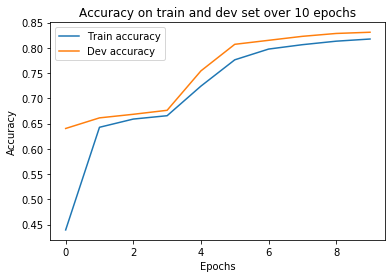

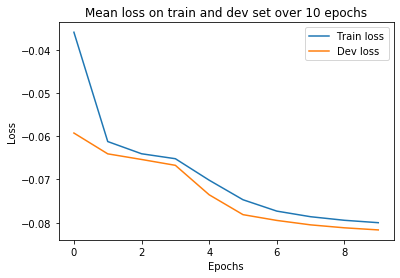

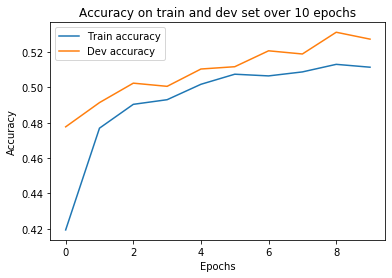

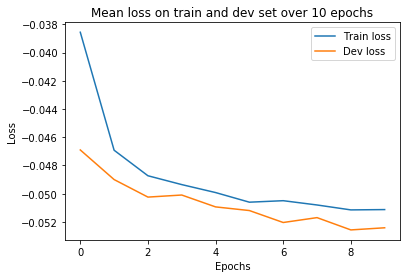

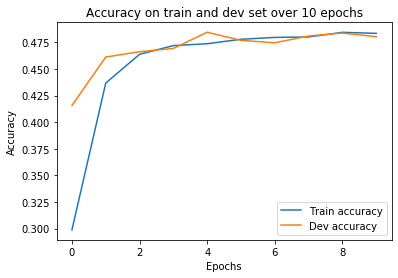

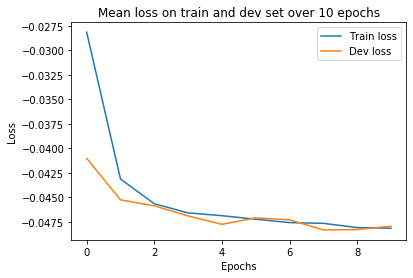

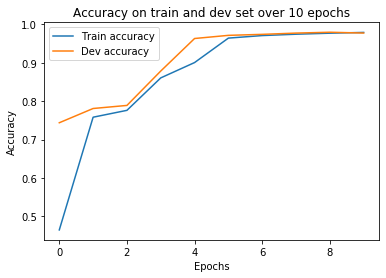

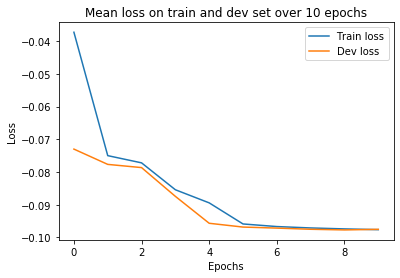

In [47]:
for m in stat_dict: 
    plt.plot(stat_dict[m][0], label= "Train accuracy")
    plt.plot(stat_dict[m][2], label="Dev accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy on train and dev set over 10 epochs")
    plt.savefig('accuracy_{}.png'.format(m))
    plt.show()

    plt.plot(stat_dict[m][1], label= "Train loss")
    plt.plot(stat_dict[m][3], label="Dev loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Mean loss on train and dev set over 10 epochs")
    plt.savefig('loss_{}.png'.format(m))
    plt.show()

[0.8948, 0.5183, 0.5675, 0.8949]


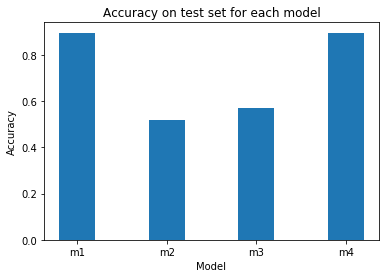

In [80]:
barWidth = 0.4
test_acc = [stat_dict[m][4][0] for m in stat_dict]
print(test_acc)
x = range(4)
models = ["m1","m2","m3","m4",]
plt.bar(x, test_acc, width=barWidth)
plt.xticks(range(len(test_acc)), models)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy on test set for each model")
plt.savefig('accuracy_test.png')
plt.show()

## 1.4. Bonus: Convolutional Neural Network

You can try to rely on a CNN instead of a MLP to classify MNIST images (you can still have a single layer MLP on top of convolutions, after pooling!). Note that this will requires you to reshape the input images!

# Part 2: Variational Auto-Encoder

To build a new Variational Auto-Encoder, you need two networks:

- An encoder that will take as input an image and compute the parameters of list of Normal distributions
- A decoder that will take a sample from each Normal distribution and will output an image

For simplicity we will assume that:

- each network as a single hidden layer of size 100
- the latent space contains only 2 points

To understand exactly what a VAE is, you can:


- check the slides of Michèle Sebag
- check this tutorial: https://arxiv.org/abs/1606.05908

## 1.2. Encoder
- Compute an hidden representation:  $z = relu(W^1x+b^1)$
- Compute the means of the normal distributions:  $mu=W^2x+b^2$
- Compute the log variance of the normal distributions:  $log_{sigma^2}=W^3x+b^3$

## 1.2. Decoder
This a simple MLP, nothing new here!

## 1.3. Training loss
To compute the training loss, you must compute two terms:

- a Monte-Carlo estimation of the reconstruction loss
- the KL divergence between the distributions computed by the encoder and the prior

To sample values, you can use the reparameterization trick as follows:

In [48]:
#VARIATIONAL AUTOENCODEUR

##Encodeur
class Encodeur(nn.Module):
    def __init__(self):
        super(Encodeur, self).__init__()
        self.el1 = nn.Linear(784,100)
        self.el21 = nn.Linear(100,2)
        self.el22 = nn.Linear(100,2)
        
    def encode(self, x):
        k = F.relu(self.el1(x))
        return self.el21(k), self.el22(k)

    def reparam_trick(self, mean, std):
        std = std.mul(0.5).exp_()
        e = th.FloatTensor(std.size()).normal_()
#         e=Variable(e)
        return e.mul(std).add_(mean)

    def forward(self, x):
        mean, std = self.encode(x)
        z = self.reparam_trick(mean, std)
        return z, mean, std
    
##Decodeur
class Decodeur(nn.Module):
    def __init__(self):
        super(Decodeur, self).__init__()
        self.dl1 = nn.Linear(2,100)
        self.dl2 = nn.Linear(100,784)
        
    def forward(self, x):
        x = F.relu(self.dl1(x))
        return self.dl2(x)


For the reconstruction loss, use the Binary Cross Entropy loss:

In [49]:
loss_fn = nn.BCEWithLogitsLoss(reduction="sum")

The formula of the KL divergence with the prior is as follows:

In [50]:
def loss_function(recon, x, m, log_s):
    """
    recon: batch généré 
    x: images d'origine
    mu: moyenne latente
    logvar: log_sigma latent
    """
    r_err = loss_fn(recon, x)  # bce loss

    KLD = m.pow(2).add_(log_s.exp()).mul_(-1).add_(1).add_(log_s)
    KLD = th.sum(KLD).mul_(-0.5)

    return r_err + KLD

## 1.4. Recomended hyper parameters
- Optimizer: Adam
- N. epochs: 50
- Use gradient clipping!
- Large batch size, e.g. 128

In [73]:
encoder = Encodeur()
decoder = Decodeur()
lr = 1e-3
stat_dict["vae"] = []

In [74]:
def train_vae(enc, dec, batch_size, max_epochs=5, conv=False):
    optim = th.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))
    for i in range(max_epochs):
        mean_loss = 0
        batches = get_batches(batch_size, train_data)
        for x, _ in batches:
            data = th.from_numpy(x)
            z_batch, mu, sigma = enc(data)
            recon_batch = dec(z_batch)
            loss = loss_function(recon_batch, data, mu, sigma)
            mean_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            th.nn.utils.clip_grad_value_(itertools.chain(encoder.parameters(), decoder.parameters()), 5.)
            optim.step()
        
        stat_dict["vae"].append(mean_loss/(len(train_data[0])*batch_size))
        
        print("EPOCH {}".format(i+1))
        print("Mean loss : ",mean_loss/(len(train_data[0])*batch_size))
        #Dessin d'un forward par époque
        
        z, _,_ = enc.forward(th.from_numpy(train_data[0][0]))
        recon = th.sigmoid(dec(z))
        reconNp = recon.detach().numpy()
        fig = plt.figure()
        a=fig.add_subplot(1,2,1)
        plt.imshow(reconNp.reshape(28,28) , matplotlib.pyplot.cm.gray) 
        a.set_title('image encodée+décodée')
        if(i%10==0):
            fig.savefig('train_recon_{}.png'.format(i))
        a=fig.add_subplot(1,2,2)
        plt.imshow(train_data[0][0].reshape(28,28), matplotlib.pyplot.cm.gray)
        a.set_title("image d'origine")
        plt.show()
        print("----------------------------------------")

EPOCH 1
Mean loss :  1.650485147857666


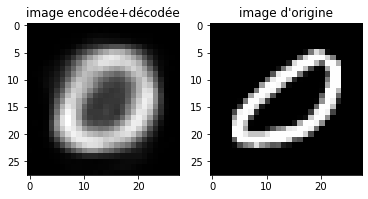

----------------------------------------
EPOCH 2
Mean loss :  1.3677959634399415


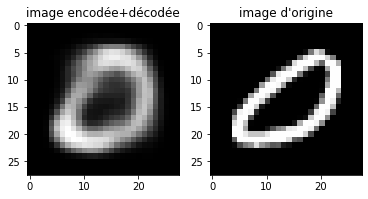

----------------------------------------
EPOCH 3
Mean loss :  1.3285109158325195


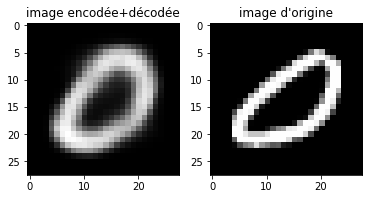

----------------------------------------
EPOCH 4
Mean loss :  1.303529444732666


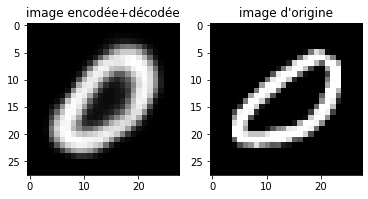

----------------------------------------
EPOCH 5
Mean loss :  1.2888932206726074


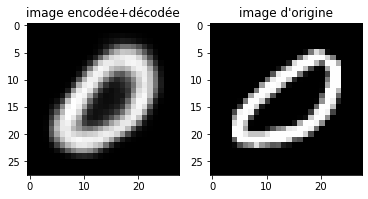

----------------------------------------
EPOCH 6
Mean loss :  1.278472031402588


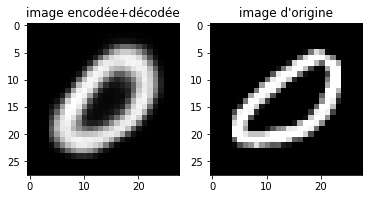

----------------------------------------
EPOCH 7
Mean loss :  1.2701345739746093


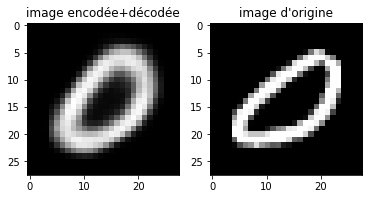

----------------------------------------
EPOCH 8
Mean loss :  1.2634517510986327


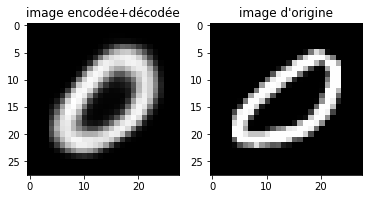

----------------------------------------
EPOCH 9
Mean loss :  1.2571116589355469


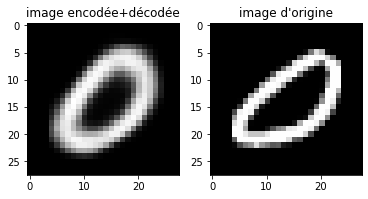

----------------------------------------
EPOCH 10
Mean loss :  1.252058701171875


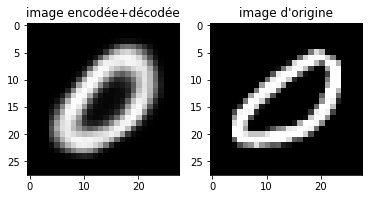

----------------------------------------
EPOCH 11
Mean loss :  1.2476281178283692


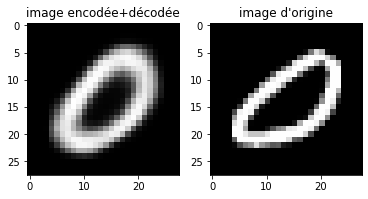

----------------------------------------
EPOCH 12
Mean loss :  1.2434349562072753


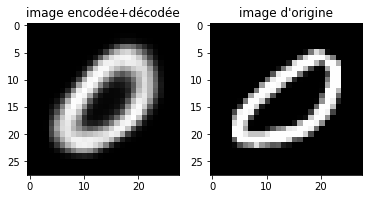

----------------------------------------
EPOCH 13
Mean loss :  1.2399820072937011


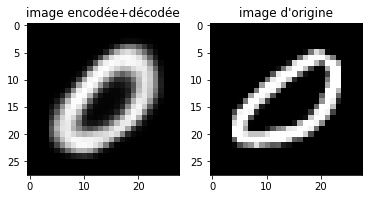

----------------------------------------
EPOCH 14
Mean loss :  1.237239557800293


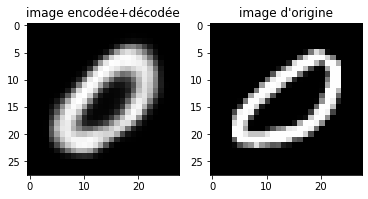

----------------------------------------
EPOCH 15
Mean loss :  1.2346449304199218


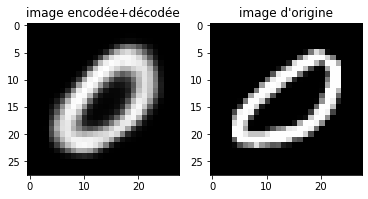

----------------------------------------
EPOCH 16
Mean loss :  1.2316880018615723


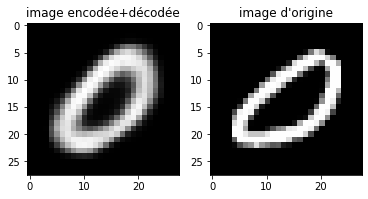

----------------------------------------
EPOCH 17
Mean loss :  1.228940817718506


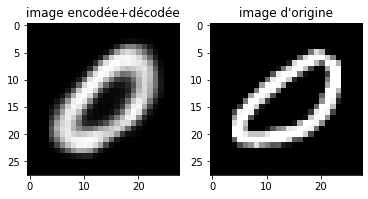

----------------------------------------
EPOCH 18
Mean loss :  1.2269181953430175


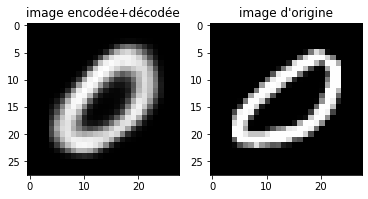

----------------------------------------
EPOCH 19
Mean loss :  1.2251144812011718


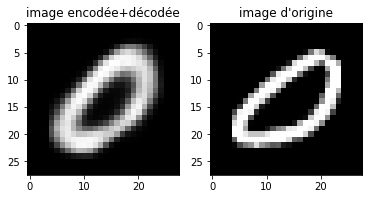

----------------------------------------
EPOCH 20
Mean loss :  1.2235494271850587


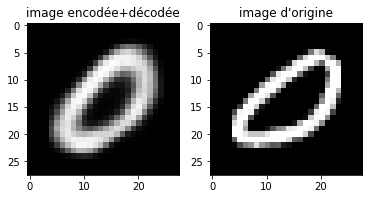

----------------------------------------
EPOCH 21
Mean loss :  1.221719577331543


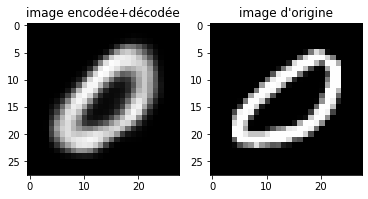

----------------------------------------
EPOCH 22
Mean loss :  1.2203795425415038


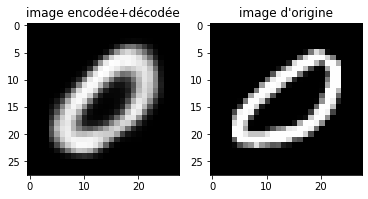

----------------------------------------
EPOCH 23
Mean loss :  1.218758590698242


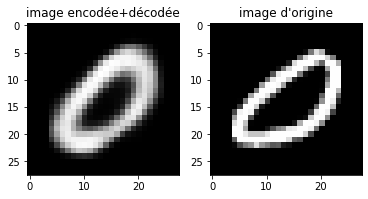

----------------------------------------
EPOCH 24
Mean loss :  1.2170326983642579


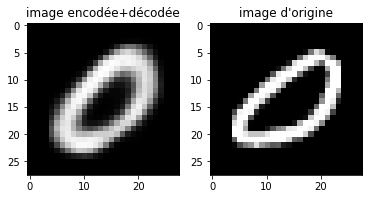

----------------------------------------
EPOCH 25
Mean loss :  1.216272395172119


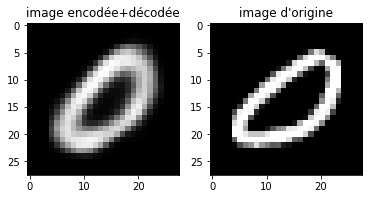

----------------------------------------
EPOCH 26
Mean loss :  1.2146846047973632


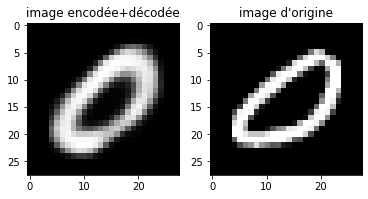

----------------------------------------
EPOCH 27
Mean loss :  1.2127979936218263


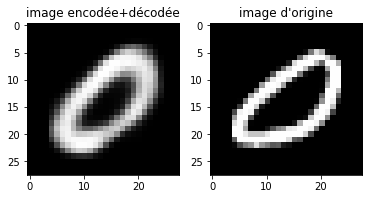

----------------------------------------
EPOCH 28
Mean loss :  1.2115167333984376


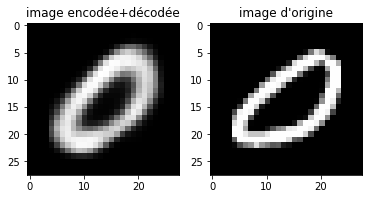

----------------------------------------
EPOCH 29
Mean loss :  1.2105912280273436


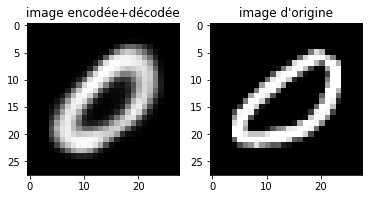

----------------------------------------
EPOCH 30
Mean loss :  1.2094925


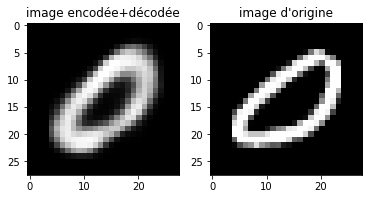

----------------------------------------
EPOCH 31
Mean loss :  1.2079526119995116


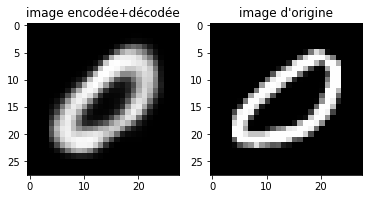

----------------------------------------
EPOCH 32
Mean loss :  1.2068049635314941


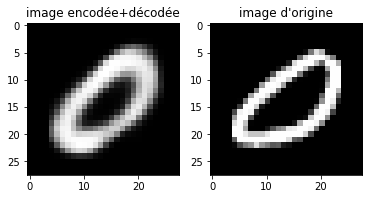

----------------------------------------
EPOCH 33
Mean loss :  1.2060731921386718


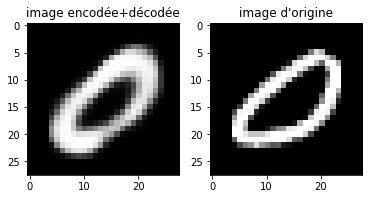

----------------------------------------
EPOCH 34
Mean loss :  1.205128526611328


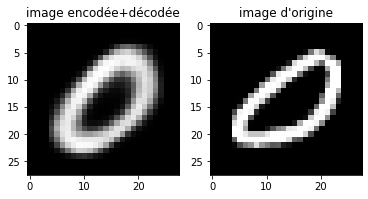

----------------------------------------
EPOCH 35
Mean loss :  1.203549666748047


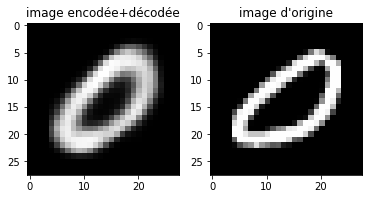

----------------------------------------
EPOCH 36
Mean loss :  1.202621107940674


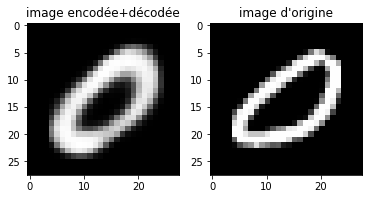

----------------------------------------
EPOCH 37
Mean loss :  1.201953475189209


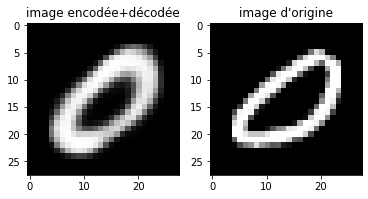

----------------------------------------
EPOCH 38
Mean loss :  1.2012777529907226


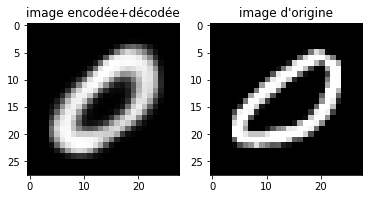

----------------------------------------
EPOCH 39
Mean loss :  1.199827526550293


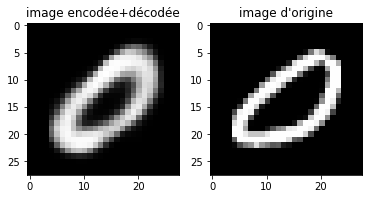

----------------------------------------
EPOCH 40
Mean loss :  1.199055525970459


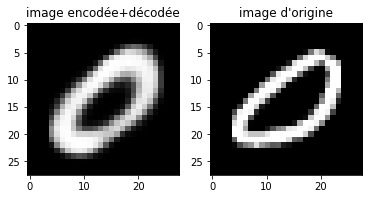

----------------------------------------
EPOCH 41
Mean loss :  1.198512241973877


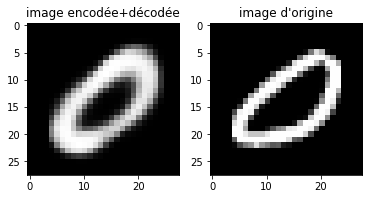

----------------------------------------
EPOCH 42
Mean loss :  1.198267852935791


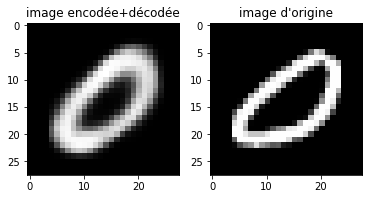

----------------------------------------
EPOCH 43
Mean loss :  1.1974364729309082


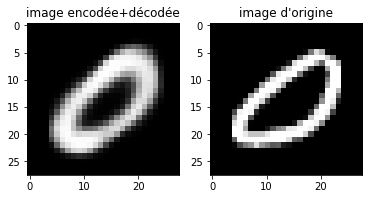

----------------------------------------
EPOCH 44
Mean loss :  1.1967728256225585


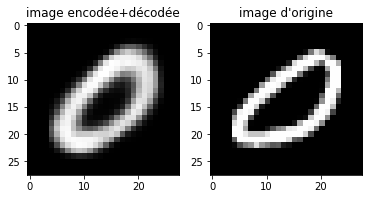

----------------------------------------
EPOCH 45
Mean loss :  1.1960050173950196


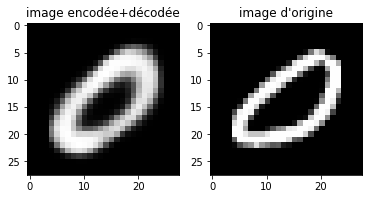

----------------------------------------
EPOCH 46
Mean loss :  1.1952720751953125


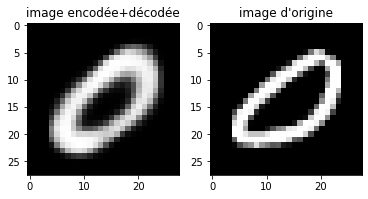

----------------------------------------
EPOCH 47
Mean loss :  1.1949334831237792


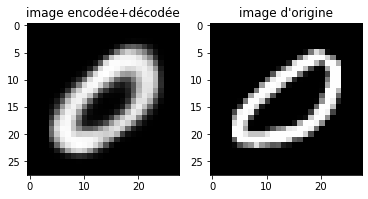

----------------------------------------
EPOCH 48
Mean loss :  1.194271220855713


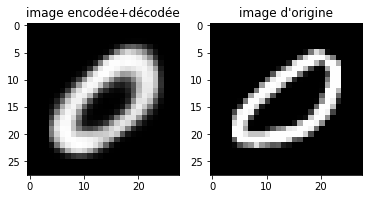

----------------------------------------
EPOCH 49
Mean loss :  1.1937257469177247


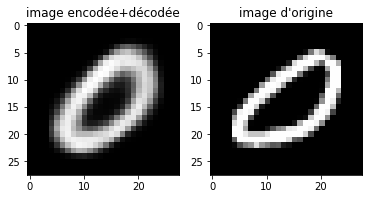

----------------------------------------
EPOCH 50
Mean loss :  1.1932050343322753


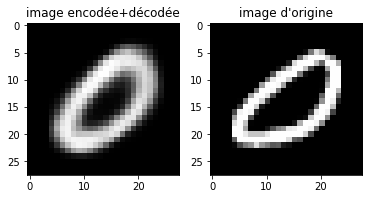

----------------------------------------


In [75]:
train_vae(encoder, decoder,128, max_epochs=50)

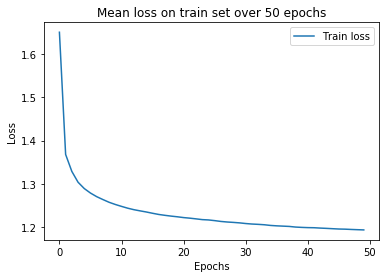

In [76]:
plt.plot(stat_dict["vae"], label= "Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Mean loss on train set over 50 epochs")
plt.savefig('loss_vae.png'.format(m))
plt.show()

## 1.5. Generate new images
Note: they will be blurry, but that's ok!

tensor([[-0.2226,  0.7679],
        [-1.8841, -0.3448],
        [ 0.0902, -0.4243],
        [ 0.6678, -1.5354],
        [ 0.9823,  0.4256],
        [ 0.5636,  0.0624],
        [-1.7059, -1.8594],
        [-0.0433,  1.8398],
        [-0.3468,  0.6698],
        [ 0.5058, -0.9716]])


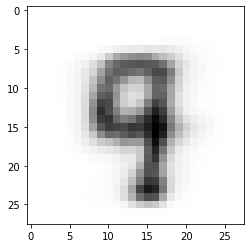

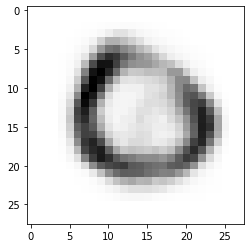

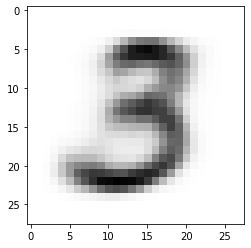

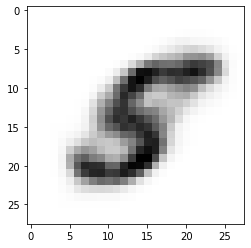

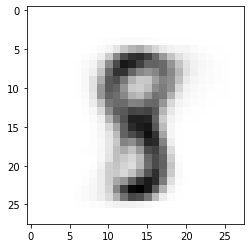

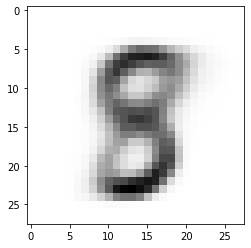

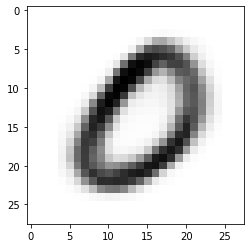

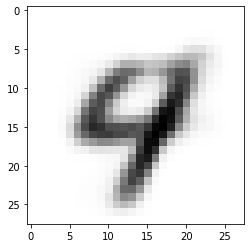

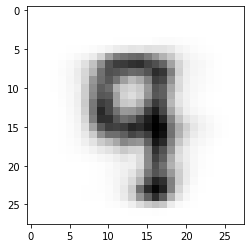

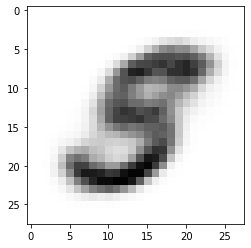

In [77]:
# e = th.normal(0., 1., (10, 2))
e = th.empty((10,2)).normal_(mean=0,std=1)
print(e)
images = th.sigmoid(decoder(e))

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.savefig('gen_{}.png'.format(i))
    plt.show()